Notebook prepared by Henrique Lopes Cardoso (hlc@fe.up.pt), based on [Named Entity Recognition and Classification with Scikit-Learn](https://www.kdnuggets.com/2018/10/named-entity-recognition-classification-scikit-learn.html) by Susan Li.

# SEQUENCE LABELING TRAINING

## Training a NER model

To train a model on NER, we need to rely on an annotated dataset. For the purpose of this notebook, we'll use the [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus), which has been annotated with POS and named entities, using BIO encoding.

This is what the dataset (a CSV file) looks like:

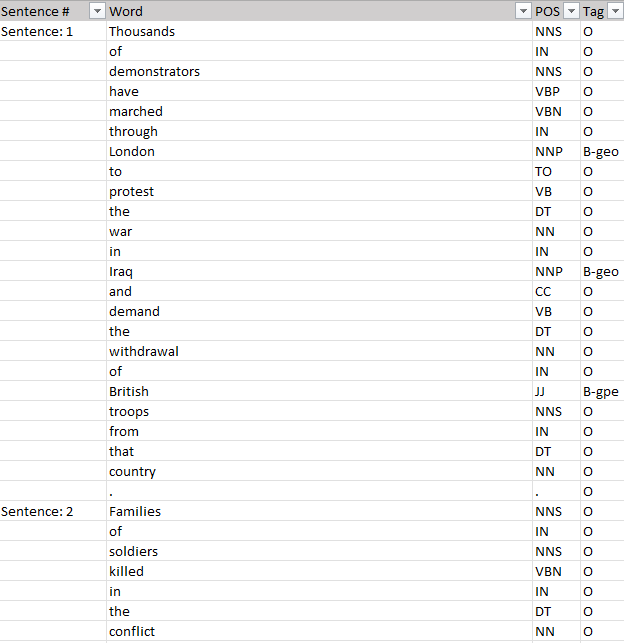

Let's load the data and have a look on it.

In [8]:
import pandas as pd

# loading NER data
df = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")

df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


There are several rows for which the first column (*Sentence #*) is *NaN*. This is because only the first token in each sentence is signaled with the sentence number.

How many *NaN*s are there?

In [2]:
# your code here
df['Sentence #'].isna().sum()

1000616

We could choose to get rid of that first column. However, for reasons that will later become evident, we'll fill down the sentence number to all tokens in each sentence.

In [9]:
df = df.fillna(method='ffill')
df[:25]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Let's see now how many sentences we've got:

In [4]:
df['Sentence #'].nunique()

47959

How many words, POS and BIO tags are there?

In [5]:
# your code here
nwords = df['Word'].nunique()
nPOS = df['POS'].nunique()
nTags = df['Tag'].nunique()
print(nwords, nPOS, nTags)

35178 42 17


Let's check the distribution of POS tags:

In [6]:
df.groupby('POS').size().reset_index(name='counts')

,POS,counts
0,$,1149
1,",",32757
2,.,47831
3,:,795
4,;,214
5,CC,23716
6,CD,24695
7,DT,98454
8,EX,663
9,FW,1


What is the distribution of named entity BIO tags?

In [7]:
# your code here
df.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


As expected, we have a very unbalanced dataset in terms of NER tags. Which is the most prevalent named entity type? What types tend to be composed of a single word?

### Can we do it with "traditional" classifiers?

First we generate our dataset for training the NER model. Adding the POS tag to the word seems to be a good idea -- hopefully the word's POS is helpful to determine whether the word corresponds to a named entity. We can get rid of the sentence number, though, as it does not seem to add anything useful for the task.

In [10]:
X = df[['Word', 'POS']]

Let's also collect the BIO labels for the words:

In [11]:
y = df['Tag'].values

Let's check the shape of our feature matrix:

In [10]:
print(X.shape)
print(y.shape)

(1048575, 2)
(1048575,)


We need to transform each data entry into a 1-hot vector, for which we can use [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html). This will create a table with as many columns as the number of unique words and POS tags we have in our dataset -- the features we'll use to represent each token of the text.

In [11]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=True) # sparse=False will use much more memory, and take much longer to train...
X = v.fit_transform(X.to_dict('records'))

Now we split the dataset into training and test sets (we should be more careful by obtaining a test set that starts at the beginning of a sentence, but let's disregard this for now):

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0, stratify=y)

If the full data set is too big to fit into memory, we'll need to use mini-batches of data to train the model with an [out-of-core learning](https://scikit-learn.org/0.15/modules/scaling_strategies.html) algorithm.

Try training a traditional classifier, such as MultinomialNB. How well does it perform?

In [13]:
def batch(iterable_X, iterable_y, n=1):
    l = iterable_X.shape[0]
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]

In [26]:
classes = list(set(y))

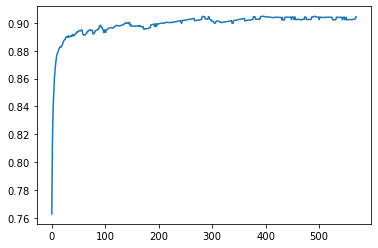

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

clf = MultinomialNB()
 
accuracy = []
ROUNDS = 6
for round in range(ROUNDS):
    batcherator = batch(X_train, y_train, 10000)
    for index, (chunk_X, chunk_y) in enumerate(batcherator):
        #print('hello')
        clf.partial_fit(chunk_X, chunk_y, classes=classes)
 
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))
plt.plot(accuracy)

The model seems to have a good accuracy, but that's too misleading -- the dataset is very unbalanced, with many *O* (outside) labels. If we look at macro average f1-score, we observe unsatisfactory results.

Try out other classifiers, namely those that support [out-of-core](https://scikit-learn.org/0.15/modules/scaling_strategies.html) learning, such as:
- Perceptron
- SGDClassifier
- PassiveAggressiveClassifier

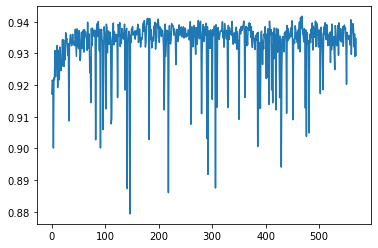

In [28]:
# your code here
from sklearn.linear_model import PassiveAggressiveClassifier

clf = PassiveAggressiveClassifier()
 
accuracy = []
ROUNDS = 6
for round in range(ROUNDS):
    batcherator = batch(X_train, y_train, 10000)
    for index, (chunk_X, chunk_y) in enumerate(batcherator):
        #print('hello')
        clf.partial_fit(chunk_X, chunk_y, classes=classes)
 
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))
plt.plot(accuracy)

Turning to classifiers tailored for sequence labeling tasks!

### Conditional Random Fields

Conditional Random Fields is one of the most well known algorithms for dealing with sequential data, and is very useful for sequence labeling tasks.
We will make use of [sklearn-crfsuite](https://sklearn-crfsuite.readthedocs.io/en/latest/), which implements a CRF classifier.

#### Splitting into sentences

Let's first reconstruct the sentences with their POS and NER tags:

In [12]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

sentences = SentenceGetter(df).sentences

Let's see what we've got, by printing the sequences of words, POS and NER labels for a few sentences:

In [13]:
def pprint_sentence(sent):
    for token in sent:
        print(token[0], end =" ")
    print()
    for token in sent:
        print(token[1], end =" ")
    print()
    for token in sent:
        print(token[2], end =" ")
    print('\n')
    return

pprint_sentence(sentences[0])
pprint_sentence(sentences[1])
pprint_sentence(sentences[2])

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . 
NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP CC VB DT NN IN JJ NNS IN DT NN . 
O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O 

Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning . 
JJ NNS VBP PRP VBP TO VB NN TO JJ JJ NNS IN DT NN NNP , IN DT NNP NN NN VBZ VBG . 
B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O 

Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan . 
NN NNS NNP VBD JJ NNS IN DT NNP JJ NN , WRB JJ NNP NNS VBP VBN TO VB VBN TO VB DT JJR JJ NN IN JJ NNP NNP . 
O O B-tim O O O O O B-geo O O O O O B-org O O O O O O O O O O O O O O B-geo I-geo O 



#### Feature extraction

Next, we extract more features (word parts, simplified POS tags, lower/title/upper flags, features of nearby words) and convert them to sklearn-crfsuite format -- each sentence should be converted to a list of dicts. (The following code was taken from the [sklearn-crfsuite tutorial](https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html).)

In [14]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [15]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

Let's have a look at the features we get for a specific token:

In [16]:
pprint_sentence(sentences[0])
X[0][6]

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . 
NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP CC VB DT NN IN JJ NNS IN DT NN . 
O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O 



{'bias': 1.0,
 'word.lower()': 'london',
 'word[-3:]': 'don',
 'word[-2:]': 'on',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NNP',
 'postag[:2]': 'NN',
 '-1:word.lower()': 'through',
 '-1:word.istitle()': False,
 '-1:word.isupper()': False,
 '-1:postag': 'IN',
 '-1:postag[:2]': 'IN',
 '+1:word.lower()': 'to',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'TO',
 '+1:postag[:2]': 'TO'}

We're good to go: let's split the data into training and test sets so that we can employ the CRF model.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

#### Training a CRF model

We will make use of [sklearn-crfsuite](https://sklearn-crfsuite.readthedocs.io/en/latest/), which implements a CRF classifier.

In [18]:
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
crf.fit(X_train, y_train)

C:\Users\ineso\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [19]:
from sklearn_crfsuite import metrics

y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred))

C:\Users\ineso\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-art       0.44      0.11      0.18        73
       B-eve       0.54      0.38      0.45        50
       B-geo       0.87      0.90      0.88      5656
       B-gpe       0.96      0.94      0.95      2388
       B-nat       0.95      0.49      0.64        37
       B-org       0.80      0.75      0.77      3020
       B-per       0.85      0.83      0.84      2559
       B-tim       0.92      0.89      0.91      3112
       I-art       0.19      0.07      0.10        46
       I-eve       0.45      0.33      0.38        43
       I-geo       0.83      0.79      0.81      1140
       I-gpe       0.86      0.53      0.65        34
       I-nat       1.00      0.55      0.71        11
       I-org       0.81      0.80      0.81      2501
       I-per       0.85      0.91      0.88      2607
       I-tim       0.83      0.78      0.81      1016
           O       0.99      0.99      0.99    131916

    accuracy              

What did the CRF classifier learn? Look at the output of the following code and interpret it.

In [20]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I-art  -> I-art   7.391358
B-art  -> I-art   7.278202
B-nat  -> I-nat   6.479038
B-eve  -> I-eve   5.839108
I-eve  -> I-eve   5.758097
I-tim  -> I-tim   4.742140
I-gpe  -> I-gpe   4.730158
B-gpe  -> I-gpe   4.557278
B-tim  -> I-tim   4.334957
I-org  -> I-org   4.290097
B-geo  -> I-geo   4.277619
B-org  -> I-org   4.241753
I-nat  -> I-nat   3.921685
B-per  -> I-per   3.738044
O      -> O       3.633986
I-geo  -> I-geo   3.570474
I-per  -> I-per   3.148476
I-geo  -> B-art   1.880411
O      -> B-per   1.824350
B-org  -> B-art   1.528514

Top unlikely transitions:
I-org  -> B-org   -4.203153
I-per  -> I-org   -4.227562
B-org  -> I-geo   -4.255245
I-org  -> I-geo   -4.298919
B-geo  -> B-geo   -4.499268
B-per  -> I-org   -4.704401
B-geo  -> I-per   -4.778787
B-tim  -> B-tim   -4.786172
I-org  -> I-per   -4.928529
B-geo  -> I-org   -5.109382
B-org  -> I-per   -5.115562
B-gpe  -> I-geo   -5.174884
B-gpe  -> I-org   -5.675065
I-per  -> B-per   -5.787749
B-gpe  -> B-gpe  

Checking state features:

In [21]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(20))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-20:])

Top positive:
7.845206 O        word.lower():last
7.786359 O        word.lower():month
7.580241 B-per    word.lower():vice
7.133286 B-org    word.lower():philippine
7.017612 B-tim    word.lower():multi-candidate
6.509159 B-gpe    word.lower():afghan
6.494892 B-gpe    word.lower():nepal
6.474656 B-tim    word.lower():2000
6.408125 B-gpe    word.lower():niger
6.340409 B-gpe    word.lower():german
6.220968 B-per    word.lower():obama
6.020412 B-tim    word.lower():february
5.957609 B-tim    word.lower():january
5.838123 B-org    word.lower():al-qaida
5.836919 B-org    word.lower():mid-march
5.777816 B-geo    word.lower():mid-march
5.750286 O        word.lower():chairman
5.706728 B-nat    word.lower():katrina
5.662584 O        BOS
5.659179 I-gpe    +1:word.lower():mayor

Top negative:
-3.604030 O        postag:NNP
-3.650103 O        word[-3:]:1st
-3.667834 O        word.lower():one-fourth
-3.669180 O        +1:word.lower():ms.
-3.681832 I-org    word.lower():secretary
-3.710592 O        +1

Using [ELI5](https://eli5.readthedocs.io/en/latest/index.html) we can visualize the CRF model weights (for state transitions and feature importance):

In [22]:
import eli5

eli5.show_weights(crf, top=10)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.634,0.668,-3.806,0.587,-4.164,0.923,-7.803,0.206,-3.366,0.101,-3.255,1.074,-7.414,1.824,-6.344,1.393,-6.991
B-art,-0.078,0.0,7.278,0.0,-0.111,-0.395,-1.382,-0.874,-0.249,0.0,0.0,0.103,-1.986,-1.129,-1.814,-0.001,-1.277
I-art,-0.214,-0.088,7.391,0.0,0.0,-0.105,-1.259,-0.67,0.0,0.0,0.0,-0.861,-1.543,-0.778,-1.578,-0.618,-1.021
B-eve,-0.95,0.0,0.0,-0.27,5.839,-1.317,-1.651,-1.239,-0.385,-0.524,-0.046,-1.685,-2.094,-2.312,-1.887,-0.16,-1.611
I-eve,-0.025,0.0,0.0,-2.127,5.758,-0.824,-1.199,-0.705,0.0,0.0,0.0,-0.931,-1.461,-1.382,-1.243,-1.382,-1.293
B-geo,0.314,1.021,-1.753,-1.393,-2.042,-4.499,4.278,0.051,-3.567,-0.458,-1.489,-0.369,-5.109,-1.535,-4.779,1.012,-3.853
I-geo,0.129,1.88,-0.815,-0.238,-1.203,-2.859,3.57,-1.332,-1.713,0.0,-0.55,-0.384,-3.787,-0.615,-3.501,0.472,-2.767
B-gpe,0.534,-0.994,-1.473,-0.92,-2.38,-0.066,-5.175,-5.94,4.557,-0.796,-0.884,1.156,-5.675,-0.299,-4.117,-0.575,-3.432
I-gpe,-0.02,0.0,0.0,0.0,0.0,-0.361,-1.818,-1.365,4.73,0.0,0.0,-1.884,-1.476,-0.756,-1.238,-0.906,-0.648
B-nat,-0.308,0.0,0.0,0.0,0.0,-0.409,-0.489,-0.71,0.0,-0.27,6.479,-0.334,-0.762,-1.052,-1.292,-0.002,-0.385


In [23]:
eli5.show_weights(crf, top=10, targets=['O', 'B-org', 'I-per'])

In [24]:
eli5.show_weights(crf, top=10, feature_re='^word\.is', horizontal_layout=False, show=['targets'])

Weight?,Feature
-1.586,word.isdigit()
-1.901,word.isupper()
-3.380,word.istitle()
Weight?,Feature
+0.725,word.isupper()
+0.171,word.isdigit()
-0.223,word.istitle()
Weight?,Feature
+0.927,word.isdigit()
+0.316,word.isupper()
